In [1]:
import os
import torch
import scipy.io
import torch.nn as nn  # Import nn module
import torch.optim as optim  # Import optim module
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import matplotlib.pyplot as plt
from hyperspectral_dataset import HyperspectralDataset, compute_statistics, NormalizeCube, NormalizeProfile
from rgb_dataset import RGBDataset
from torchvision.transforms import Resize, CenterCrop, Compose, Normalize, ToTensor
from transformers import AutoImageProcessor, AutoModelForImageClassification




from ResNet import CustomResNet50  # Assuming ResNet50 is defined in ResNet.py
import torch
print(torch.cuda.is_available())  # Should return True
print(torch.cuda.get_device_name(0))  # Should print the name of your GPU
# Check for CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Create a random tensor and move it to the GPU
x = torch.rand(10000, 10000).to(device)
y = torch.rand(10000, 10000).to(device)

# Perform a matrix multiplication on the GPU
z = torch.matmul(x, y)

print("Matrix multiplication result:", z)
print("Done.")



Original x:  tensor([ 0.6902,  0.6215,  0.4694,  0.1650, -1.9970, -0.8147,  0.6160, -1.5974,
        -0.3525, -0.3261])
Reconstructed x:  tensor([ 0.6902,  0.6215,  0.4694,  0.1650, -1.9970, -0.8147,  0.6160, -1.5974,
        -0.3525, -0.3261])
Difference:  tensor(4.6290e-07)
True
NVIDIA GeForce RTX 4070
Using device: cuda
Using device: cuda
Matrix multiplication result: tensor([[2512.7634, 2510.5347, 2500.3145,  ..., 2546.4805, 2517.5903,
         2510.8586],
        [2470.5537, 2480.1965, 2446.0208,  ..., 2470.6821, 2471.3079,
         2485.0737],
        [2494.2124, 2521.3318, 2471.4602,  ..., 2528.4626, 2521.2471,
         2511.4089],
        ...,
        [2488.7749, 2494.0759, 2454.2747,  ..., 2507.7656, 2491.0725,
         2494.5911],
        [2517.9812, 2527.2366, 2469.6465,  ..., 2535.4807, 2513.1624,
         2510.1604],
        [2483.6794, 2514.6897, 2473.9929,  ..., 2535.6189, 2515.1772,
         2504.4287]], device='cuda:0')
Done.


In [2]:
# Function to get all file paths from a dataset
def get_all_file_paths(dataset):
    file_paths = []
    # for idx in range(len(dataset)):
    file_paths.append(dataset.get_image_path(idx))
    return file_paths

# # Initialize the dataset with transformations
# dataset = RGBDataset(root_dir='../../../serverstuff/hsi/all')
# channel_means_cube, channel_stds_cube, channel_means_profile, channel_stds_profile = compute_statistics(dataset)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

# Apply the custom transforms to the datasets
train_dataset = RGBDataset(root_dir='../../../serverstuff/hsi/train', transform=transform)
val_dataset = RGBDataset(root_dir='../../../serverstuff/hsi/validation', transform=transform)
test_dataset = RGBDataset(root_dir='../../../serverstuff/hsi/test', transform=transform)

# Create DataLoaders for training, validation, and test sets
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=4)

Label mapping: {'Acinetobacter_baumanii': 0, 'Lactobacillus_casei': 1, 'Lactobacillus_jehnsenii': 2, 'Lactobacillus_gasseri': 3, 'Lactobacillus_delbrueckii': 4, 'Lactobacillus_salivarius': 5, 'Propionibacterium_acnes': 6, 'Lactobacillus_paracasei': 7, 'Bifidobacterium_spp': 8, 'Lactobacillus_reuteri': 9, 'Staphylococcus_aureus': 10, 'Escherichia_coli': 11, 'Lactobacillus_rhamnosus': 12, 'Lactobacillus_plantarum': 13, 'Enterococcus_faecium': 14, 'Porfyromonas_gingivalis': 15, 'Enterococcus_faecalis': 16, 'Micrococcus_spp': 17, 'Fusobacterium': 18, 'Actinomyces_israeli': 19, 'Lactobacillus_crispatus': 20, 'Clostridium_perfringens': 21, 'Staphylococcus_epidermidis': 22, 'Listeria_monocytogenes': 23, 'Pseudomonas_aeruginosa': 24, 'Lactobacillus_johnsonii': 26, 'Streptococcus_agalactiae': 27, 'Staphylococcus_saprophiticus': 28, 'Bacteroides_fragilis': 29, 'Neisseria_gonorrhoeae': 30, 'Veionella': 31, 'Proteus': 32, 'Candida_albicans': 33}
Label mapping: {'Acinetobacter_baumanii': 0, 'Lactob

In [3]:
# # Function to get all file paths from a dataset
# def get_all_file_paths(dataset):
#     file_paths = []
#     for idx in range(len(dataset)):
#         file_paths.append(dataset.get_image_path(idx))
#     return file_paths

# # # Initialize the dataset with transformations
# dataset = HyperspectralDataset(root_dir='../../dibasRP/all')
# # channel_means_cube, channel_stds_cube, channel_means_profile, channel_stds_profile = compute_statistics(dataset)

# channel_means_cube, channel_stds_cube, channel_means_profile, channel_stds_profile = [0.5] * 31, [0.5] * 31, [0.5] * 31, [0.5] * 31
# # Define the custom transformations using the computed statistics
# cube_transform = NormalizeCube(mean=channel_means_cube, std=channel_stds_cube)
# profile_transform = NormalizeProfile(mean=channel_means_profile, std=channel_stds_profile)

# # Apply the custom transforms to the datasets
# train_dataset = HyperspectralDataset(root_dir='../../dibasRP/train', cube_transform=cube_transform)
# val_dataset = HyperspectralDataset(root_dir='../../dibasRP/val', cube_transform=cube_transform)
# test_dataset = HyperspectralDataset(root_dir='../../dibasRP/test', cube_transform=cube_transform)

# # Create DataLoaders for training, validation, and test sets
# train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
# val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)
# test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=4)

In [4]:
# # Get file paths for the main dataset and each split
# main_dataset_paths = get_all_file_paths(dataset)
# train_dataset_paths = get_all_file_paths(train_dataset)
# val_dataset_paths = get_all_file_paths(val_dataset)
# test_dataset_paths = get_all_file_paths(test_dataset)

# # Check if the total length of the splits equals the length of the main dataset
# total_split_length = len(train_dataset_paths) + len(val_dataset_paths) + len(test_dataset_paths)
# if total_split_length != len(main_dataset_paths):
#     print(f"Error: Total length of splits ({total_split_length}) does not equal length of main dataset ({len(main_dataset_paths)})")
# else:
#     print("Total length of splits matches the length of the main dataset.")

# # Check for overlaps between splits
# def check_for_overlaps(paths1, paths2):
#     overlaps = set(paths1) & set(paths2)
#     return overlaps

# train_val_overlaps = check_for_overlaps(train_dataset_paths, val_dataset_paths)
# train_test_overlaps = check_for_overlaps(train_dataset_paths, test_dataset_paths)
# val_test_overlaps = check_for_overlaps(val_dataset_paths, test_dataset_paths)

# if train_val_overlaps:
#     print(f"Error: Overlaps found between train and validation datasets: {len(train_val_overlaps)} overlaps")
# else:
#     print("No overlaps found between train and validation datasets.")

# if train_test_overlaps:
#     print(f"Error: Overlaps found between train and test datasets: {len(train_test_overlaps)} overlaps")
# else:
#     print("No overlaps found between train and test datasets.")

# if val_test_overlaps:
#     print(f"Error: Overlaps found between validation and test datasets: {len(val_test_overlaps)} overlaps")
# else:
#     print("No overlaps found between validation and test datasets.")

In [5]:
# Initialize the modified ResNet model

model = AutoModelForImageClassification.from_pretrained("google/efficientnet-b3").to(device)

# model = CustomResNet50(num_classes=len(train_dataset.label_map)).to(device)
# model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1).to(device)
for name, param in model.named_parameters():
    param.requires_grad = "classifier" in name

# Get the number of input features of the current classifier layer
num_features = model.classifier.in_features

# Replace the classifier layer with a new one
model.classifier = nn.Linear(num_features, 34).to(device)  # Assuming 10 classes

print(model.classifier.out_features)
    

for name, param in model.named_parameters():
    print(f"{name}: {'requires_grad' if param.requires_grad else 'frozen'}")


config.json:   0%|          | 0.00/70.2k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/49.5M [00:00<?, ?B/s]

34
efficientnet.embeddings.convolution.weight: frozen
efficientnet.embeddings.batchnorm.weight: frozen
efficientnet.embeddings.batchnorm.bias: frozen
efficientnet.encoder.blocks.0.depthwise_conv.depthwise_conv.weight: frozen
efficientnet.encoder.blocks.0.depthwise_conv.depthwise_norm.weight: frozen
efficientnet.encoder.blocks.0.depthwise_conv.depthwise_norm.bias: frozen
efficientnet.encoder.blocks.0.squeeze_excite.reduce.weight: frozen
efficientnet.encoder.blocks.0.squeeze_excite.reduce.bias: frozen
efficientnet.encoder.blocks.0.squeeze_excite.expand.weight: frozen
efficientnet.encoder.blocks.0.squeeze_excite.expand.bias: frozen
efficientnet.encoder.blocks.0.projection.project_conv.weight: frozen
efficientnet.encoder.blocks.0.projection.project_bn.weight: frozen
efficientnet.encoder.blocks.0.projection.project_bn.bias: frozen
efficientnet.encoder.blocks.1.depthwise_conv.depthwise_conv.weight: frozen
efficientnet.encoder.blocks.1.depthwise_conv.depthwise_norm.weight: frozen
efficientnet

In [6]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)
# optimizer = optim.Adam(model.parameters(), lr=0.001)

optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.5, patience=5)



In [7]:
import time
from sklearn.metrics import precision_recall_fscore_support

# Initialize lists to store losses, accuracy, and learning rate change epochs
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
train_precisions = []
train_recalls = []
train_f1_scores = []
val_precisions = []
val_recalls = []
val_f1_scores = []
lr_change_epochs = []

# Training and validation loop
num_epochs = 125  # Set the number of epochs
for epoch in range(num_epochs):
    epoch_start_time = time.time()  # Start timing the epoch

    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    all_train_labels = []
    all_train_preds = []

    for batch_idx, (cubes, labels) in enumerate(train_loader):
        cubes, labels = cubes.to(device), labels.to(device)  # Move data to GPU
        optimizer.zero_grad()  # Zero the parameter gradients

        # Forward pass
        outputs = model(cubes)
        loss = criterion(outputs.logits, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.logits, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        # Store labels and predictions for precision, recall, f1
        all_train_labels.extend(labels.cpu().numpy())
        all_train_preds.extend(predicted.cpu().numpy())

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Calculate precision, recall, f1 score for training
    train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(all_train_labels, all_train_preds, average='weighted')
    train_precisions.append(train_precision)
    train_recalls.append(train_recall)
    train_f1_scores.append(train_f1)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Precision: {train_precision:.3f}, Recall: {train_recall:.3f}, F1 Score: {train_f1:.3f}")

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    all_val_labels = []
    all_val_preds = []

    with torch.no_grad():
        for cubes, labels in val_loader:
            cubes, labels = cubes.to(device), labels.to(device)  # Move data to GPU
            outputs = model(cubes)
            loss = criterion(outputs.logits, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.logits, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

            # Store labels and predictions for precision, recall, f1
            all_val_labels.extend(labels.cpu().numpy())
            all_val_preds.extend(predicted.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)

    # Calculate precision, recall, f1 score for validation
    val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(all_val_labels, all_val_preds, average='weighted')
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_f1_scores.append(val_f1)

    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%, Precision: {val_precision:.3f}, Recall: {val_recall:.3f}, F1 Score: {val_f1:.3f}")

    current_lr = optimizer.param_groups[0]['lr']
    scheduler.step(avg_val_loss)
    new_lr = optimizer.param_groups[0]['lr']
    if new_lr < current_lr:
        print(f"Learning rate reduced from {current_lr} to {new_lr}")
        lr_change_epochs.append(epoch+1)  # Log the epoch where the learning rate changed

    epoch_end_time = time.time()  # End timing the epoch
    epoch_duration = epoch_end_time - epoch_start_time
    print(f"Epoch [{epoch+1}/{num_epochs}] completed in {epoch_duration:.2f} seconds")

print("Training complete.")


Epoch [1/125], Loss: 2.9541, Training Accuracy: 26.31%, Precision: 0.342, Recall: 0.263, F1 Score: 0.263


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Loss: 3.2399, Validation Accuracy: 6.58%, Precision: 0.074, Recall: 0.066, F1 Score: 0.051
Epoch [1/125] completed in 12.14 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [2/125], Loss: 1.9771, Training Accuracy: 53.73%, Precision: 0.543, Recall: 0.537, F1 Score: 0.524
Validation Loss: 2712.9865, Validation Accuracy: 31.58%, Precision: 0.247, Recall: 0.316, F1 Score: 0.242
Epoch [2/125] completed in 11.94 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [3/125], Loss: 1.5831, Training Accuracy: 62.87%, Precision: 0.629, Recall: 0.629, F1 Score: 0.616
Validation Loss: 2.2615, Validation Accuracy: 44.74%, Precision: 0.493, Recall: 0.447, F1 Score: 0.435
Epoch [3/125] completed in 12.13 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [4/125], Loss: 1.3314, Training Accuracy: 69.96%, Precision: 0.706, Recall: 0.700, F1 Score: 0.698
Validation Loss: 2.5752, Validation Accuracy: 25.00%, Precision: 0.228, Recall: 0.250, F1 Score: 0.208
Epoch [4/125] completed in 12.00 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [5/125], Loss: 1.2161, Training Accuracy: 68.84%, Precision: 0.693, Recall: 0.688, F1 Score: 0.685
Validation Loss: 1.7901, Validation Accuracy: 53.95%, Precision: 0.513, Recall: 0.539, F1 Score: 0.489
Epoch [5/125] completed in 12.05 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [6/125], Loss: 1.0910, Training Accuracy: 72.57%, Precision: 0.741, Recall: 0.726, F1 Score: 0.726
Validation Loss: 1.8413, Validation Accuracy: 59.21%, Precision: 0.583, Recall: 0.592, F1 Score: 0.550
Epoch [6/125] completed in 11.99 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [7/125], Loss: 1.0283, Training Accuracy: 72.76%, Precision: 0.734, Recall: 0.728, F1 Score: 0.724
Validation Loss: 2.8271, Validation Accuracy: 25.00%, Precision: 0.273, Recall: 0.250, F1 Score: 0.242
Epoch [7/125] completed in 12.12 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [8/125], Loss: 1.0303, Training Accuracy: 73.32%, Precision: 0.744, Recall: 0.733, F1 Score: 0.732
Validation Loss: 1.7681, Validation Accuracy: 52.63%, Precision: 0.509, Recall: 0.526, F1 Score: 0.482
Epoch [8/125] completed in 12.03 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [9/125], Loss: 0.8627, Training Accuracy: 77.24%, Precision: 0.777, Recall: 0.772, F1 Score: 0.770
Validation Loss: 2.0940, Validation Accuracy: 44.74%, Precision: 0.445, Recall: 0.447, F1 Score: 0.402
Epoch [9/125] completed in 11.92 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [10/125], Loss: 0.8561, Training Accuracy: 76.87%, Precision: 0.773, Recall: 0.769, F1 Score: 0.767
Validation Loss: 1431.0302, Validation Accuracy: 35.53%, Precision: 0.340, Recall: 0.355, F1 Score: 0.315
Epoch [10/125] completed in 11.89 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [11/125], Loss: 0.7148, Training Accuracy: 83.40%, Precision: 0.838, Recall: 0.834, F1 Score: 0.831
Validation Loss: 9.1831, Validation Accuracy: 42.11%, Precision: 0.351, Recall: 0.421, F1 Score: 0.349
Epoch [11/125] completed in 12.03 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [12/125], Loss: 0.7286, Training Accuracy: 81.90%, Precision: 0.821, Recall: 0.819, F1 Score: 0.816
Validation Loss: 2.9065, Validation Accuracy: 38.16%, Precision: 0.358, Recall: 0.382, F1 Score: 0.335
Epoch [12/125] completed in 11.93 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [13/125], Loss: 0.8273, Training Accuracy: 78.92%, Precision: 0.795, Recall: 0.789, F1 Score: 0.789
Validation Loss: 2.0723, Validation Accuracy: 44.74%, Precision: 0.389, Recall: 0.447, F1 Score: 0.395
Epoch [13/125] completed in 11.99 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [14/125], Loss: 0.8086, Training Accuracy: 75.37%, Precision: 0.752, Recall: 0.754, F1 Score: 0.748
Validation Loss: 1.8667, Validation Accuracy: 53.95%, Precision: 0.563, Recall: 0.539, F1 Score: 0.515
Learning rate reduced from 0.001 to 0.0005
Epoch [14/125] completed in 12.02 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [15/125], Loss: 0.7051, Training Accuracy: 81.53%, Precision: 0.819, Recall: 0.815, F1 Score: 0.815
Validation Loss: 1.4760, Validation Accuracy: 60.53%, Precision: 0.686, Recall: 0.605, F1 Score: 0.592
Epoch [15/125] completed in 11.94 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [16/125], Loss: 0.6623, Training Accuracy: 83.21%, Precision: 0.841, Recall: 0.832, F1 Score: 0.832
Validation Loss: 1.1496, Validation Accuracy: 69.74%, Precision: 0.726, Recall: 0.697, F1 Score: 0.672
Epoch [16/125] completed in 12.03 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [17/125], Loss: 0.6023, Training Accuracy: 83.96%, Precision: 0.844, Recall: 0.840, F1 Score: 0.840
Validation Loss: 2.2756, Validation Accuracy: 51.32%, Precision: 0.571, Recall: 0.513, F1 Score: 0.493
Epoch [17/125] completed in 12.00 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [18/125], Loss: 0.6604, Training Accuracy: 84.89%, Precision: 0.853, Recall: 0.849, F1 Score: 0.847
Validation Loss: 1.8796, Validation Accuracy: 47.37%, Precision: 0.465, Recall: 0.474, F1 Score: 0.437
Epoch [18/125] completed in 11.90 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [19/125], Loss: 0.6891, Training Accuracy: 82.28%, Precision: 0.826, Recall: 0.823, F1 Score: 0.821
Validation Loss: 2.4006, Validation Accuracy: 39.47%, Precision: 0.420, Recall: 0.395, F1 Score: 0.379
Epoch [19/125] completed in 11.98 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [20/125], Loss: 0.6061, Training Accuracy: 83.40%, Precision: 0.840, Recall: 0.834, F1 Score: 0.834
Validation Loss: 2.6626, Validation Accuracy: 25.00%, Precision: 0.314, Recall: 0.250, F1 Score: 0.258
Epoch [20/125] completed in 11.97 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [21/125], Loss: 0.5646, Training Accuracy: 83.58%, Precision: 0.839, Recall: 0.836, F1 Score: 0.833
Validation Loss: 217.3514, Validation Accuracy: 23.68%, Precision: 0.267, Recall: 0.237, F1 Score: 0.213
Epoch [21/125] completed in 11.94 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [22/125], Loss: 0.5959, Training Accuracy: 82.28%, Precision: 0.827, Recall: 0.823, F1 Score: 0.822
Validation Loss: 1.4086, Validation Accuracy: 61.84%, Precision: 0.620, Recall: 0.618, F1 Score: 0.599
Learning rate reduced from 0.0005 to 0.00025
Epoch [22/125] completed in 11.95 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [23/125], Loss: 0.6606, Training Accuracy: 82.84%, Precision: 0.835, Recall: 0.828, F1 Score: 0.827
Validation Loss: 2.3450, Validation Accuracy: 35.53%, Precision: 0.328, Recall: 0.355, F1 Score: 0.314
Epoch [23/125] completed in 11.95 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [24/125], Loss: 0.6296, Training Accuracy: 83.96%, Precision: 0.848, Recall: 0.840, F1 Score: 0.840
Validation Loss: 1.4819, Validation Accuracy: 56.58%, Precision: 0.524, Recall: 0.566, F1 Score: 0.512
Epoch [24/125] completed in 11.99 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [25/125], Loss: 0.6079, Training Accuracy: 83.40%, Precision: 0.838, Recall: 0.834, F1 Score: 0.831
Validation Loss: 1.5844, Validation Accuracy: 55.26%, Precision: 0.509, Recall: 0.553, F1 Score: 0.508
Epoch [25/125] completed in 12.02 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [26/125], Loss: 0.5579, Training Accuracy: 83.58%, Precision: 0.841, Recall: 0.836, F1 Score: 0.835
Validation Loss: 1.8678, Validation Accuracy: 56.58%, Precision: 0.605, Recall: 0.566, F1 Score: 0.547
Epoch [26/125] completed in 12.02 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [27/125], Loss: 0.6054, Training Accuracy: 84.14%, Precision: 0.845, Recall: 0.841, F1 Score: 0.839
Validation Loss: 2.5155, Validation Accuracy: 34.21%, Precision: 0.427, Recall: 0.342, F1 Score: 0.325
Epoch [27/125] completed in 11.95 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [28/125], Loss: 0.5458, Training Accuracy: 85.26%, Precision: 0.858, Recall: 0.853, F1 Score: 0.852
Validation Loss: 1.8528, Validation Accuracy: 53.95%, Precision: 0.471, Recall: 0.539, F1 Score: 0.467
Learning rate reduced from 0.00025 to 0.000125
Epoch [28/125] completed in 12.01 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [29/125], Loss: 0.5313, Training Accuracy: 86.01%, Precision: 0.866, Recall: 0.860, F1 Score: 0.859
Validation Loss: 1.1831, Validation Accuracy: 65.79%, Precision: 0.647, Recall: 0.658, F1 Score: 0.621
Epoch [29/125] completed in 11.90 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [30/125], Loss: 0.5745, Training Accuracy: 84.70%, Precision: 0.852, Recall: 0.847, F1 Score: 0.847
Validation Loss: 2.6869, Validation Accuracy: 23.68%, Precision: 0.311, Recall: 0.237, F1 Score: 0.242
Epoch [30/125] completed in 12.02 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [31/125], Loss: 0.4909, Training Accuracy: 87.87%, Precision: 0.882, Recall: 0.879, F1 Score: 0.878
Validation Loss: 9911.5233, Validation Accuracy: 31.58%, Precision: 0.316, Recall: 0.316, F1 Score: 0.294
Epoch [31/125] completed in 12.01 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [32/125], Loss: 0.5953, Training Accuracy: 83.02%, Precision: 0.836, Recall: 0.830, F1 Score: 0.831
Validation Loss: 1.6553, Validation Accuracy: 53.95%, Precision: 0.565, Recall: 0.539, F1 Score: 0.504
Epoch [32/125] completed in 11.95 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [33/125], Loss: 0.5335, Training Accuracy: 85.26%, Precision: 0.857, Recall: 0.853, F1 Score: 0.850
Validation Loss: 1.1737, Validation Accuracy: 67.11%, Precision: 0.679, Recall: 0.671, F1 Score: 0.644
Epoch [33/125] completed in 12.04 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [34/125], Loss: 0.5580, Training Accuracy: 84.51%, Precision: 0.853, Recall: 0.845, F1 Score: 0.845
Validation Loss: 1.5374, Validation Accuracy: 57.89%, Precision: 0.544, Recall: 0.579, F1 Score: 0.527
Learning rate reduced from 0.000125 to 6.25e-05
Epoch [34/125] completed in 11.96 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [35/125], Loss: 0.5283, Training Accuracy: 85.45%, Precision: 0.860, Recall: 0.854, F1 Score: 0.855
Validation Loss: 2222.6954, Validation Accuracy: 38.16%, Precision: 0.328, Recall: 0.382, F1 Score: 0.322
Epoch [35/125] completed in 11.96 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [36/125], Loss: 0.5543, Training Accuracy: 85.26%, Precision: 0.859, Recall: 0.853, F1 Score: 0.852
Validation Loss: 1.8759, Validation Accuracy: 44.74%, Precision: 0.502, Recall: 0.447, F1 Score: 0.437
Epoch [36/125] completed in 11.90 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [37/125], Loss: 0.5278, Training Accuracy: 85.26%, Precision: 0.857, Recall: 0.853, F1 Score: 0.852
Validation Loss: 2.4897, Validation Accuracy: 32.89%, Precision: 0.374, Recall: 0.329, F1 Score: 0.323
Epoch [37/125] completed in 11.99 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [38/125], Loss: 0.4980, Training Accuracy: 87.50%, Precision: 0.883, Recall: 0.875, F1 Score: 0.875
Validation Loss: 1.5701, Validation Accuracy: 63.16%, Precision: 0.612, Recall: 0.632, F1 Score: 0.590
Epoch [38/125] completed in 11.94 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [39/125], Loss: 0.5557, Training Accuracy: 85.26%, Precision: 0.855, Recall: 0.853, F1 Score: 0.851
Validation Loss: 2.1376, Validation Accuracy: 46.05%, Precision: 0.434, Recall: 0.461, F1 Score: 0.416
Epoch [39/125] completed in 12.11 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [40/125], Loss: 0.5193, Training Accuracy: 86.38%, Precision: 0.872, Recall: 0.864, F1 Score: 0.865
Validation Loss: 1.7440, Validation Accuracy: 46.05%, Precision: 0.509, Recall: 0.461, F1 Score: 0.442
Learning rate reduced from 6.25e-05 to 3.125e-05
Epoch [40/125] completed in 11.94 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [41/125], Loss: 0.5730, Training Accuracy: 83.58%, Precision: 0.844, Recall: 0.836, F1 Score: 0.834
Validation Loss: 2.0107, Validation Accuracy: 46.05%, Precision: 0.487, Recall: 0.461, F1 Score: 0.437
Epoch [41/125] completed in 12.01 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [42/125], Loss: 0.4585, Training Accuracy: 87.50%, Precision: 0.882, Recall: 0.875, F1 Score: 0.875
Validation Loss: 2.3612, Validation Accuracy: 28.95%, Precision: 0.347, Recall: 0.289, F1 Score: 0.298
Epoch [42/125] completed in 11.93 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [43/125], Loss: 0.5309, Training Accuracy: 87.13%, Precision: 0.873, Recall: 0.871, F1 Score: 0.869
Validation Loss: 1.5485, Validation Accuracy: 57.89%, Precision: 0.546, Recall: 0.579, F1 Score: 0.534
Epoch [43/125] completed in 12.02 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [44/125], Loss: 0.5654, Training Accuracy: 84.33%, Precision: 0.848, Recall: 0.843, F1 Score: 0.842
Validation Loss: 2.0005, Validation Accuracy: 44.74%, Precision: 0.411, Recall: 0.447, F1 Score: 0.402
Epoch [44/125] completed in 12.02 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [45/125], Loss: 0.5104, Training Accuracy: 87.13%, Precision: 0.875, Recall: 0.871, F1 Score: 0.871
Validation Loss: 1.8872, Validation Accuracy: 47.37%, Precision: 0.529, Recall: 0.474, F1 Score: 0.475
Epoch [45/125] completed in 11.91 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [46/125], Loss: 0.5143, Training Accuracy: 87.13%, Precision: 0.878, Recall: 0.871, F1 Score: 0.872
Validation Loss: 2.1690, Validation Accuracy: 40.79%, Precision: 0.399, Recall: 0.408, F1 Score: 0.368
Learning rate reduced from 3.125e-05 to 1.5625e-05
Epoch [46/125] completed in 12.05 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [47/125], Loss: 0.5035, Training Accuracy: 87.31%, Precision: 0.878, Recall: 0.873, F1 Score: 0.872
Validation Loss: 1.5011, Validation Accuracy: 64.47%, Precision: 0.664, Recall: 0.645, F1 Score: 0.611
Epoch [47/125] completed in 11.98 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [48/125], Loss: 0.5661, Training Accuracy: 83.96%, Precision: 0.848, Recall: 0.840, F1 Score: 0.841
Validation Loss: 3.4602, Validation Accuracy: 17.11%, Precision: 0.185, Recall: 0.171, F1 Score: 0.173
Epoch [48/125] completed in 12.01 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [49/125], Loss: 0.5948, Training Accuracy: 82.46%, Precision: 0.829, Recall: 0.825, F1 Score: 0.823
Validation Loss: 2.7109, Validation Accuracy: 27.63%, Precision: 0.238, Recall: 0.276, F1 Score: 0.245
Epoch [49/125] completed in 12.05 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [50/125], Loss: 0.5015, Training Accuracy: 88.25%, Precision: 0.884, Recall: 0.882, F1 Score: 0.880
Validation Loss: 1.6039, Validation Accuracy: 61.84%, Precision: 0.593, Recall: 0.618, F1 Score: 0.583
Epoch [50/125] completed in 12.06 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [51/125], Loss: 0.5788, Training Accuracy: 84.70%, Precision: 0.852, Recall: 0.847, F1 Score: 0.847
Validation Loss: 1.7024, Validation Accuracy: 57.89%, Precision: 0.643, Recall: 0.579, F1 Score: 0.562
Epoch [51/125] completed in 11.94 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [52/125], Loss: 0.6075, Training Accuracy: 83.21%, Precision: 0.838, Recall: 0.832, F1 Score: 0.829
Validation Loss: 2158.3265, Validation Accuracy: 46.05%, Precision: 0.341, Recall: 0.461, F1 Score: 0.376
Learning rate reduced from 1.5625e-05 to 7.8125e-06
Epoch [52/125] completed in 11.98 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [53/125], Loss: 0.6004, Training Accuracy: 85.07%, Precision: 0.856, Recall: 0.851, F1 Score: 0.850
Validation Loss: 1.3757, Validation Accuracy: 67.11%, Precision: 0.674, Recall: 0.671, F1 Score: 0.641
Epoch [53/125] completed in 11.97 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [54/125], Loss: 0.5915, Training Accuracy: 84.14%, Precision: 0.847, Recall: 0.841, F1 Score: 0.840
Validation Loss: 2.0625, Validation Accuracy: 40.79%, Precision: 0.410, Recall: 0.408, F1 Score: 0.370
Epoch [54/125] completed in 11.92 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [55/125], Loss: 0.5349, Training Accuracy: 84.89%, Precision: 0.856, Recall: 0.849, F1 Score: 0.849
Validation Loss: 8427.3437, Validation Accuracy: 34.21%, Precision: 0.305, Recall: 0.342, F1 Score: 0.299
Epoch [55/125] completed in 12.05 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [56/125], Loss: 0.5614, Training Accuracy: 84.14%, Precision: 0.850, Recall: 0.841, F1 Score: 0.841
Validation Loss: 2.2468, Validation Accuracy: 50.00%, Precision: 0.471, Recall: 0.500, F1 Score: 0.456
Epoch [56/125] completed in 11.97 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [57/125], Loss: 0.5931, Training Accuracy: 84.51%, Precision: 0.853, Recall: 0.845, F1 Score: 0.846
Validation Loss: 2.5065, Validation Accuracy: 30.26%, Precision: 0.314, Recall: 0.303, F1 Score: 0.272
Epoch [57/125] completed in 11.94 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [58/125], Loss: 0.5645, Training Accuracy: 83.77%, Precision: 0.844, Recall: 0.838, F1 Score: 0.837
Validation Loss: 3186.9657, Validation Accuracy: 22.37%, Precision: 0.275, Recall: 0.224, F1 Score: 0.226
Learning rate reduced from 7.8125e-06 to 3.90625e-06
Epoch [58/125] completed in 11.99 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [59/125], Loss: 0.5059, Training Accuracy: 86.19%, Precision: 0.867, Recall: 0.862, F1 Score: 0.860
Validation Loss: 1.5726, Validation Accuracy: 56.58%, Precision: 0.604, Recall: 0.566, F1 Score: 0.565
Epoch [59/125] completed in 12.06 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [60/125], Loss: 0.5055, Training Accuracy: 85.82%, Precision: 0.860, Recall: 0.858, F1 Score: 0.856
Validation Loss: 1.5138, Validation Accuracy: 56.58%, Precision: 0.548, Recall: 0.566, F1 Score: 0.531
Epoch [60/125] completed in 11.98 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [61/125], Loss: 0.5539, Training Accuracy: 85.26%, Precision: 0.857, Recall: 0.853, F1 Score: 0.852
Validation Loss: 2.4148, Validation Accuracy: 27.63%, Precision: 0.287, Recall: 0.276, F1 Score: 0.244
Epoch [61/125] completed in 11.99 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [62/125], Loss: 0.6195, Training Accuracy: 82.65%, Precision: 0.832, Recall: 0.826, F1 Score: 0.825
Validation Loss: 1.8581, Validation Accuracy: 51.32%, Precision: 0.545, Recall: 0.513, F1 Score: 0.485
Epoch [62/125] completed in 12.00 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [63/125], Loss: 0.5044, Training Accuracy: 86.94%, Precision: 0.875, Recall: 0.869, F1 Score: 0.868
Validation Loss: 10.2996, Validation Accuracy: 17.11%, Precision: 0.150, Recall: 0.171, F1 Score: 0.149
Epoch [63/125] completed in 12.04 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [64/125], Loss: 0.4885, Training Accuracy: 89.18%, Precision: 0.895, Recall: 0.892, F1 Score: 0.891
Validation Loss: 1.5404, Validation Accuracy: 57.89%, Precision: 0.630, Recall: 0.579, F1 Score: 0.565
Learning rate reduced from 3.90625e-06 to 1.953125e-06
Epoch [64/125] completed in 12.14 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [65/125], Loss: 0.4749, Training Accuracy: 87.69%, Precision: 0.880, Recall: 0.877, F1 Score: 0.875
Validation Loss: 5.5811, Validation Accuracy: 43.42%, Precision: 0.314, Recall: 0.434, F1 Score: 0.344
Epoch [65/125] completed in 12.03 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [66/125], Loss: 0.6007, Training Accuracy: 84.14%, Precision: 0.843, Recall: 0.841, F1 Score: 0.840
Validation Loss: 1.7025, Validation Accuracy: 57.89%, Precision: 0.551, Recall: 0.579, F1 Score: 0.546
Epoch [66/125] completed in 12.12 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [67/125], Loss: 0.5490, Training Accuracy: 85.26%, Precision: 0.859, Recall: 0.853, F1 Score: 0.853
Validation Loss: 686.5851, Validation Accuracy: 38.16%, Precision: 0.297, Recall: 0.382, F1 Score: 0.319
Epoch [67/125] completed in 12.23 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [68/125], Loss: 0.5069, Training Accuracy: 87.50%, Precision: 0.878, Recall: 0.875, F1 Score: 0.873
Validation Loss: 1.3769, Validation Accuracy: 59.21%, Precision: 0.612, Recall: 0.592, F1 Score: 0.555
Epoch [68/125] completed in 12.21 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [69/125], Loss: 0.4969, Training Accuracy: 88.25%, Precision: 0.885, Recall: 0.882, F1 Score: 0.881
Validation Loss: 1.8205, Validation Accuracy: 50.00%, Precision: 0.545, Recall: 0.500, F1 Score: 0.487
Epoch [69/125] completed in 12.24 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [70/125], Loss: 0.4818, Training Accuracy: 88.62%, Precision: 0.889, Recall: 0.886, F1 Score: 0.886
Validation Loss: 1.5610, Validation Accuracy: 55.26%, Precision: 0.538, Recall: 0.553, F1 Score: 0.506
Learning rate reduced from 1.953125e-06 to 9.765625e-07
Epoch [70/125] completed in 12.14 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [71/125], Loss: 0.4893, Training Accuracy: 86.19%, Precision: 0.867, Recall: 0.862, F1 Score: 0.860
Validation Loss: 0.9444, Validation Accuracy: 73.68%, Precision: 0.776, Recall: 0.737, F1 Score: 0.720
Epoch [71/125] completed in 12.18 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [72/125], Loss: 0.5795, Training Accuracy: 84.33%, Precision: 0.845, Recall: 0.843, F1 Score: 0.841
Validation Loss: 1.8897, Validation Accuracy: 53.95%, Precision: 0.489, Recall: 0.539, F1 Score: 0.478
Epoch [72/125] completed in 12.23 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [73/125], Loss: 0.4783, Training Accuracy: 88.06%, Precision: 0.888, Recall: 0.881, F1 Score: 0.881
Validation Loss: 1.7928, Validation Accuracy: 51.32%, Precision: 0.547, Recall: 0.513, F1 Score: 0.492
Epoch [73/125] completed in 12.11 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [74/125], Loss: 0.5989, Training Accuracy: 83.58%, Precision: 0.840, Recall: 0.836, F1 Score: 0.834
Validation Loss: 1.8598, Validation Accuracy: 43.42%, Precision: 0.379, Recall: 0.434, F1 Score: 0.379
Epoch [74/125] completed in 12.22 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [75/125], Loss: 0.5822, Training Accuracy: 84.51%, Precision: 0.851, Recall: 0.845, F1 Score: 0.844
Validation Loss: 1.3305, Validation Accuracy: 65.79%, Precision: 0.670, Recall: 0.658, F1 Score: 0.623
Epoch [75/125] completed in 12.14 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [76/125], Loss: 0.5043, Training Accuracy: 85.63%, Precision: 0.863, Recall: 0.856, F1 Score: 0.855
Validation Loss: 1.5729, Validation Accuracy: 59.21%, Precision: 0.559, Recall: 0.592, F1 Score: 0.542
Epoch [76/125] completed in 12.17 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [77/125], Loss: 0.5709, Training Accuracy: 84.89%, Precision: 0.856, Recall: 0.849, F1 Score: 0.848
Validation Loss: 1.3346, Validation Accuracy: 64.47%, Precision: 0.689, Recall: 0.645, F1 Score: 0.630
Learning rate reduced from 9.765625e-07 to 4.8828125e-07
Epoch [77/125] completed in 12.14 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [78/125], Loss: 0.5576, Training Accuracy: 84.51%, Precision: 0.852, Recall: 0.845, F1 Score: 0.845
Validation Loss: 1.7131, Validation Accuracy: 48.68%, Precision: 0.537, Recall: 0.487, F1 Score: 0.482
Epoch [78/125] completed in 12.04 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [79/125], Loss: 0.5750, Training Accuracy: 84.89%, Precision: 0.854, Recall: 0.849, F1 Score: 0.848
Validation Loss: 2.1452, Validation Accuracy: 48.68%, Precision: 0.532, Recall: 0.487, F1 Score: 0.473
Epoch [79/125] completed in 12.20 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [80/125], Loss: 0.5458, Training Accuracy: 84.89%, Precision: 0.853, Recall: 0.849, F1 Score: 0.847
Validation Loss: 5955.9557, Validation Accuracy: 21.05%, Precision: 0.187, Recall: 0.211, F1 Score: 0.174
Epoch [80/125] completed in 12.21 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [81/125], Loss: 0.4531, Training Accuracy: 88.62%, Precision: 0.889, Recall: 0.886, F1 Score: 0.886
Validation Loss: 2.3392, Validation Accuracy: 39.47%, Precision: 0.324, Recall: 0.395, F1 Score: 0.333
Epoch [81/125] completed in 12.20 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [82/125], Loss: 0.5247, Training Accuracy: 85.63%, Precision: 0.861, Recall: 0.856, F1 Score: 0.855
Validation Loss: 2.1268, Validation Accuracy: 38.16%, Precision: 0.355, Recall: 0.382, F1 Score: 0.332
Epoch [82/125] completed in 12.22 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [83/125], Loss: 0.5531, Training Accuracy: 85.26%, Precision: 0.861, Recall: 0.853, F1 Score: 0.852
Validation Loss: 2.5802, Validation Accuracy: 23.68%, Precision: 0.283, Recall: 0.237, F1 Score: 0.242
Learning rate reduced from 4.8828125e-07 to 2.44140625e-07
Epoch [83/125] completed in 12.23 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [84/125], Loss: 0.5119, Training Accuracy: 86.75%, Precision: 0.872, Recall: 0.868, F1 Score: 0.867
Validation Loss: 1518.3828, Validation Accuracy: 26.32%, Precision: 0.241, Recall: 0.263, F1 Score: 0.227
Epoch [84/125] completed in 12.17 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [85/125], Loss: 0.5212, Training Accuracy: 86.57%, Precision: 0.872, Recall: 0.866, F1 Score: 0.865
Validation Loss: 2.7495, Validation Accuracy: 44.74%, Precision: 0.451, Recall: 0.447, F1 Score: 0.416
Epoch [85/125] completed in 12.23 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [86/125], Loss: 0.5400, Training Accuracy: 87.13%, Precision: 0.876, Recall: 0.871, F1 Score: 0.872
Validation Loss: 1.5507, Validation Accuracy: 60.53%, Precision: 0.603, Recall: 0.605, F1 Score: 0.573
Epoch [86/125] completed in 12.10 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [87/125], Loss: 0.5220, Training Accuracy: 86.94%, Precision: 0.877, Recall: 0.869, F1 Score: 0.869
Validation Loss: 1.8705, Validation Accuracy: 59.21%, Precision: 0.574, Recall: 0.592, F1 Score: 0.557
Epoch [87/125] completed in 12.14 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [88/125], Loss: 0.4723, Training Accuracy: 87.87%, Precision: 0.882, Recall: 0.879, F1 Score: 0.878
Validation Loss: 1.9946, Validation Accuracy: 46.05%, Precision: 0.443, Recall: 0.461, F1 Score: 0.416
Epoch [88/125] completed in 12.09 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [89/125], Loss: 0.5409, Training Accuracy: 86.19%, Precision: 0.864, Recall: 0.862, F1 Score: 0.860
Validation Loss: 2.4078, Validation Accuracy: 42.11%, Precision: 0.433, Recall: 0.421, F1 Score: 0.397
Learning rate reduced from 2.44140625e-07 to 1.220703125e-07
Epoch [89/125] completed in 12.20 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [90/125], Loss: 0.5527, Training Accuracy: 85.26%, Precision: 0.859, Recall: 0.853, F1 Score: 0.852
Validation Loss: 1.1111, Validation Accuracy: 75.00%, Precision: 0.748, Recall: 0.750, F1 Score: 0.715
Epoch [90/125] completed in 12.24 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [91/125], Loss: 0.5404, Training Accuracy: 85.82%, Precision: 0.862, Recall: 0.858, F1 Score: 0.858
Validation Loss: 1.6644, Validation Accuracy: 52.63%, Precision: 0.520, Recall: 0.526, F1 Score: 0.481
Epoch [91/125] completed in 12.03 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [92/125], Loss: 0.5085, Training Accuracy: 86.01%, Precision: 0.866, Recall: 0.860, F1 Score: 0.859
Validation Loss: 1.7574, Validation Accuracy: 48.68%, Precision: 0.471, Recall: 0.487, F1 Score: 0.450
Epoch [92/125] completed in 12.09 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [93/125], Loss: 0.5596, Training Accuracy: 84.89%, Precision: 0.856, Recall: 0.849, F1 Score: 0.849
Validation Loss: 1.4029, Validation Accuracy: 72.37%, Precision: 0.750, Recall: 0.724, F1 Score: 0.705
Epoch [93/125] completed in 12.22 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [94/125], Loss: 0.5900, Training Accuracy: 84.14%, Precision: 0.848, Recall: 0.841, F1 Score: 0.841
Validation Loss: 1.4931, Validation Accuracy: 59.21%, Precision: 0.572, Recall: 0.592, F1 Score: 0.557
Epoch [94/125] completed in 12.13 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [95/125], Loss: 0.5744, Training Accuracy: 83.21%, Precision: 0.836, Recall: 0.832, F1 Score: 0.832
Validation Loss: 2.0025, Validation Accuracy: 36.84%, Precision: 0.358, Recall: 0.368, F1 Score: 0.320
Learning rate reduced from 1.220703125e-07 to 6.103515625e-08
Epoch [95/125] completed in 12.19 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [96/125], Loss: 0.5161, Training Accuracy: 86.38%, Precision: 0.872, Recall: 0.864, F1 Score: 0.864
Validation Loss: 2.2290, Validation Accuracy: 31.58%, Precision: 0.318, Recall: 0.316, F1 Score: 0.292
Epoch [96/125] completed in 12.21 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [97/125], Loss: 0.5289, Training Accuracy: 87.31%, Precision: 0.875, Recall: 0.873, F1 Score: 0.871
Validation Loss: 2.2280, Validation Accuracy: 35.53%, Precision: 0.276, Recall: 0.355, F1 Score: 0.276
Epoch [97/125] completed in 12.01 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [98/125], Loss: 0.5557, Training Accuracy: 85.82%, Precision: 0.864, Recall: 0.858, F1 Score: 0.858
Validation Loss: 1.6082, Validation Accuracy: 57.89%, Precision: 0.565, Recall: 0.579, F1 Score: 0.538
Epoch [98/125] completed in 12.21 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [99/125], Loss: 0.5334, Training Accuracy: 84.70%, Precision: 0.851, Recall: 0.847, F1 Score: 0.846
Validation Loss: 1.4139, Validation Accuracy: 61.84%, Precision: 0.554, Recall: 0.618, F1 Score: 0.561
Epoch [99/125] completed in 12.20 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [100/125], Loss: 0.5322, Training Accuracy: 86.75%, Precision: 0.873, Recall: 0.868, F1 Score: 0.867
Validation Loss: 2.4124, Validation Accuracy: 40.79%, Precision: 0.459, Recall: 0.408, F1 Score: 0.398
Epoch [100/125] completed in 12.23 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [101/125], Loss: 0.5429, Training Accuracy: 86.19%, Precision: 0.866, Recall: 0.862, F1 Score: 0.861
Validation Loss: 1.5970, Validation Accuracy: 52.63%, Precision: 0.558, Recall: 0.526, F1 Score: 0.503
Learning rate reduced from 6.103515625e-08 to 3.0517578125e-08
Epoch [101/125] completed in 12.25 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [102/125], Loss: 0.4842, Training Accuracy: 86.94%, Precision: 0.878, Recall: 0.869, F1 Score: 0.870
Validation Loss: 2.0598, Validation Accuracy: 43.42%, Precision: 0.440, Recall: 0.434, F1 Score: 0.383
Epoch [102/125] completed in 12.12 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [103/125], Loss: 0.5171, Training Accuracy: 87.31%, Precision: 0.875, Recall: 0.873, F1 Score: 0.872
Validation Loss: 2.6729, Validation Accuracy: 22.37%, Precision: 0.200, Recall: 0.224, F1 Score: 0.196
Epoch [103/125] completed in 12.22 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [104/125], Loss: 0.5212, Training Accuracy: 86.19%, Precision: 0.870, Recall: 0.862, F1 Score: 0.862
Validation Loss: 8461.1190, Validation Accuracy: 35.53%, Precision: 0.327, Recall: 0.355, F1 Score: 0.321
Epoch [104/125] completed in 12.14 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [105/125], Loss: 0.5085, Training Accuracy: 86.94%, Precision: 0.881, Recall: 0.869, F1 Score: 0.868
Validation Loss: 1.9944, Validation Accuracy: 43.42%, Precision: 0.458, Recall: 0.434, F1 Score: 0.408
Epoch [105/125] completed in 12.15 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [106/125], Loss: 0.5487, Training Accuracy: 86.19%, Precision: 0.866, Recall: 0.862, F1 Score: 0.861
Validation Loss: 1.5724, Validation Accuracy: 53.95%, Precision: 0.499, Recall: 0.539, F1 Score: 0.490
Epoch [106/125] completed in 12.23 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [107/125], Loss: 0.5096, Training Accuracy: 85.82%, Precision: 0.860, Recall: 0.858, F1 Score: 0.858
Validation Loss: 1.9460, Validation Accuracy: 48.68%, Precision: 0.539, Recall: 0.487, F1 Score: 0.479
Learning rate reduced from 3.0517578125e-08 to 1.52587890625e-08
Epoch [107/125] completed in 12.20 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [108/125], Loss: 0.4788, Training Accuracy: 86.57%, Precision: 0.868, Recall: 0.866, F1 Score: 0.863
Validation Loss: 2.0126, Validation Accuracy: 46.05%, Precision: 0.444, Recall: 0.461, F1 Score: 0.404
Epoch [108/125] completed in 12.11 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [109/125], Loss: 0.5674, Training Accuracy: 86.19%, Precision: 0.869, Recall: 0.862, F1 Score: 0.862
Validation Loss: 1.9227, Validation Accuracy: 42.11%, Precision: 0.427, Recall: 0.421, F1 Score: 0.379
Epoch [109/125] completed in 12.21 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [110/125], Loss: 0.5308, Training Accuracy: 84.89%, Precision: 0.855, Recall: 0.849, F1 Score: 0.848
Validation Loss: 1.0123, Validation Accuracy: 78.95%, Precision: 0.858, Recall: 0.789, F1 Score: 0.782
Epoch [110/125] completed in 12.20 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [111/125], Loss: 0.5584, Training Accuracy: 83.58%, Precision: 0.840, Recall: 0.836, F1 Score: 0.835
Validation Loss: 61.3224, Validation Accuracy: 44.74%, Precision: 0.419, Recall: 0.447, F1 Score: 0.400
Epoch [111/125] completed in 12.03 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [112/125], Loss: 0.5229, Training Accuracy: 87.13%, Precision: 0.876, Recall: 0.871, F1 Score: 0.871
Validation Loss: 2.6065, Validation Accuracy: 35.53%, Precision: 0.407, Recall: 0.355, F1 Score: 0.350
Epoch [112/125] completed in 12.11 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [113/125], Loss: 0.5308, Training Accuracy: 85.45%, Precision: 0.862, Recall: 0.854, F1 Score: 0.853
Validation Loss: 2.5075, Validation Accuracy: 48.68%, Precision: 0.492, Recall: 0.487, F1 Score: 0.462
Epoch [113/125] completed in 12.22 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [114/125], Loss: 0.4940, Training Accuracy: 87.87%, Precision: 0.887, Recall: 0.879, F1 Score: 0.878
Validation Loss: 1.2809, Validation Accuracy: 71.05%, Precision: 0.778, Recall: 0.711, F1 Score: 0.703
Epoch [114/125] completed in 12.25 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [115/125], Loss: 0.5190, Training Accuracy: 85.82%, Precision: 0.864, Recall: 0.858, F1 Score: 0.858
Validation Loss: 2.2664, Validation Accuracy: 32.89%, Precision: 0.351, Recall: 0.329, F1 Score: 0.300
Epoch [115/125] completed in 12.26 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [116/125], Loss: 0.4726, Training Accuracy: 89.37%, Precision: 0.898, Recall: 0.894, F1 Score: 0.893
Validation Loss: 1.9856, Validation Accuracy: 44.74%, Precision: 0.424, Recall: 0.447, F1 Score: 0.404
Epoch [116/125] completed in 12.25 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [117/125], Loss: 0.5293, Training Accuracy: 86.38%, Precision: 0.868, Recall: 0.864, F1 Score: 0.863
Validation Loss: 2.3582, Validation Accuracy: 34.21%, Precision: 0.306, Recall: 0.342, F1 Score: 0.298
Epoch [117/125] completed in 12.24 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [118/125], Loss: 0.5076, Training Accuracy: 87.13%, Precision: 0.872, Recall: 0.871, F1 Score: 0.869
Validation Loss: 2.0011, Validation Accuracy: 39.47%, Precision: 0.418, Recall: 0.395, F1 Score: 0.386
Epoch [118/125] completed in 12.14 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [119/125], Loss: 0.5685, Training Accuracy: 82.84%, Precision: 0.833, Recall: 0.828, F1 Score: 0.825
Validation Loss: 1.9838, Validation Accuracy: 43.42%, Precision: 0.428, Recall: 0.434, F1 Score: 0.400
Epoch [119/125] completed in 12.06 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [120/125], Loss: 0.5777, Training Accuracy: 82.84%, Precision: 0.834, Recall: 0.828, F1 Score: 0.827
Validation Loss: 3.8682, Validation Accuracy: 48.68%, Precision: 0.443, Recall: 0.487, F1 Score: 0.438
Epoch [120/125] completed in 12.24 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [121/125], Loss: 0.4791, Training Accuracy: 86.57%, Precision: 0.873, Recall: 0.866, F1 Score: 0.865
Validation Loss: 2.3426, Validation Accuracy: 38.16%, Precision: 0.396, Recall: 0.382, F1 Score: 0.337
Epoch [121/125] completed in 12.21 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [122/125], Loss: 0.5997, Training Accuracy: 85.26%, Precision: 0.853, Recall: 0.853, F1 Score: 0.851
Validation Loss: 379.0685, Validation Accuracy: 39.47%, Precision: 0.363, Recall: 0.395, F1 Score: 0.351
Epoch [122/125] completed in 12.11 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [123/125], Loss: 0.4962, Training Accuracy: 86.38%, Precision: 0.870, Recall: 0.864, F1 Score: 0.863
Validation Loss: 2.1981, Validation Accuracy: 42.11%, Precision: 0.396, Recall: 0.421, F1 Score: 0.378
Epoch [123/125] completed in 12.13 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [124/125], Loss: 0.5191, Training Accuracy: 86.57%, Precision: 0.872, Recall: 0.866, F1 Score: 0.866
Validation Loss: 4.0689, Validation Accuracy: 42.11%, Precision: 0.431, Recall: 0.421, F1 Score: 0.389
Epoch [124/125] completed in 12.22 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [125/125], Loss: 0.5653, Training Accuracy: 86.19%, Precision: 0.870, Recall: 0.862, F1 Score: 0.862
Validation Loss: 2562.7831, Validation Accuracy: 36.84%, Precision: 0.330, Recall: 0.368, F1 Score: 0.328
Epoch [125/125] completed in 12.04 seconds
Training complete.


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


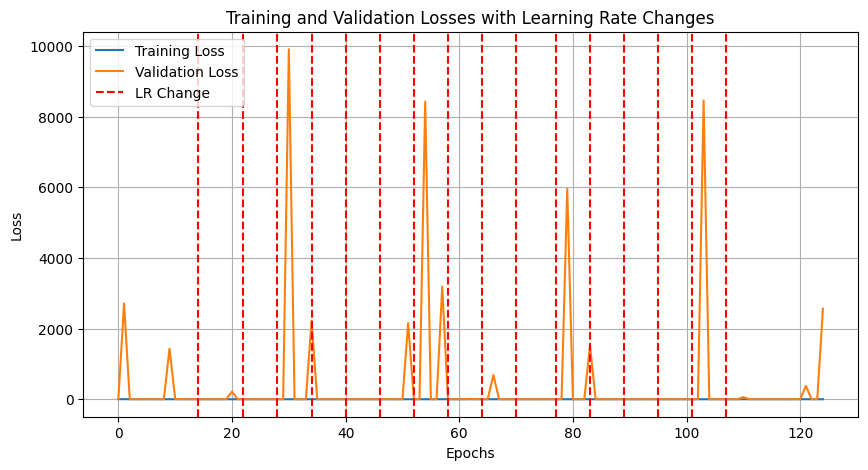

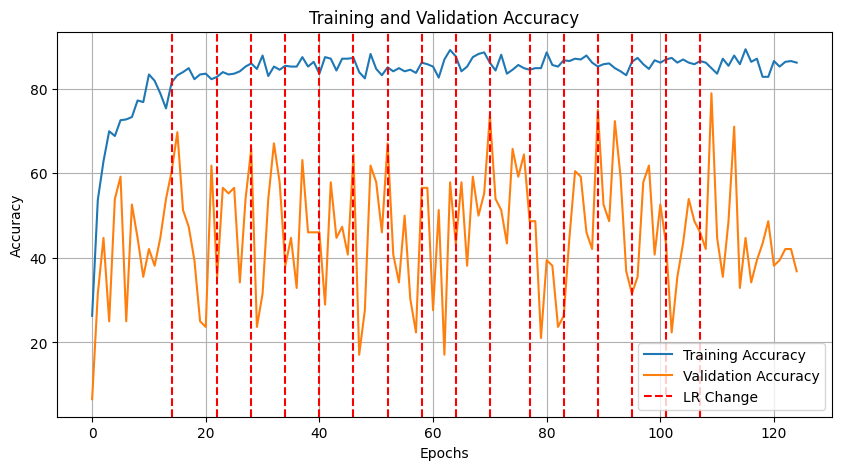

In [8]:
# Plot the training and validation losses with learning rate change points
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
for lr_epoch in lr_change_epochs:
    plt.axvline(x=lr_epoch, color='r', linestyle='--', label='LR Change' if lr_epoch == lr_change_epochs[0] else "")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses with Learning Rate Changes')
plt.grid(True)  # Add gridlines
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
for lr_epoch in lr_change_epochs:
    plt.axvline(x=lr_epoch, color='r', linestyle='--', label='LR Change' if lr_epoch == lr_change_epochs[0] else "")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.grid(True)  # Add gridlines
plt.show()


In [9]:
# Testing loop
model.eval()  # Set the model to evaluation mode
test_loss = 0.0
correct = 0
total = 0 
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
        outputs = model(inputs)
        loss = criterion(outputs.logits, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs.logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Loss: {test_loss/len(test_loader):.4f}, Test Accuracy: {accuracy:.2f}%")


Test Loss: 5482.5589, Test Accuracy: 38.96%


<Figure size 1000x1000 with 0 Axes>

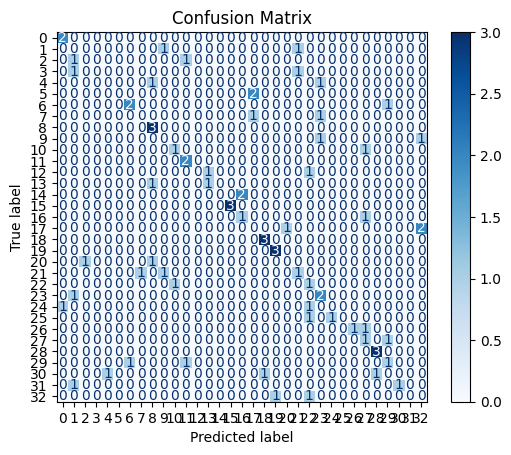

In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Function to test an individual sample and collect predictions and true labels
def test_individual_test_sample(sample_idx, true_labels, predicted_labels):
    # Load a specific sample from the test dataset
    cube, label = test_dataset[sample_idx]
    
    # Move the sample to GPU if using CUDA
    cube = cube.to(device).unsqueeze(0)  # Add batch dimension
    label = label.to(device)
    
    # Set the model to evaluation mode
    model.eval()
    
    # Disable gradient computation for inference
    with torch.no_grad():
        output = model(cube)
    
    # Apply softmax to get probabilities
    probabilities = torch.nn.functional.softmax(output.logits, dim=1)
    
    # Get the predicted class
    predicted_class = torch.argmax(probabilities, dim=1)
    
    # Append the true and predicted labels to their respective lists
    true_labels.append(label.item())
    predicted_labels.append(predicted_class.item())

# Lists to store true and predicted labels
true_labels = []
predicted_labels = []

# Test individual samples and collect labels
for i in range(len(test_dataset)):
    test_individual_test_sample(i, true_labels, predicted_labels)

# Convert lists to numpy arrays for compatibility with sklearn
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [11]:
torch.save(model.state_dict(), 'resnet.pth')

In [12]:
for name, param in model.named_parameters():
    print(name)

efficientnet.embeddings.convolution.weight
efficientnet.embeddings.batchnorm.weight
efficientnet.embeddings.batchnorm.bias
efficientnet.encoder.blocks.0.depthwise_conv.depthwise_conv.weight
efficientnet.encoder.blocks.0.depthwise_conv.depthwise_norm.weight
efficientnet.encoder.blocks.0.depthwise_conv.depthwise_norm.bias
efficientnet.encoder.blocks.0.squeeze_excite.reduce.weight
efficientnet.encoder.blocks.0.squeeze_excite.reduce.bias
efficientnet.encoder.blocks.0.squeeze_excite.expand.weight
efficientnet.encoder.blocks.0.squeeze_excite.expand.bias
efficientnet.encoder.blocks.0.projection.project_conv.weight
efficientnet.encoder.blocks.0.projection.project_bn.weight
efficientnet.encoder.blocks.0.projection.project_bn.bias
efficientnet.encoder.blocks.1.depthwise_conv.depthwise_conv.weight
efficientnet.encoder.blocks.1.depthwise_conv.depthwise_norm.weight
efficientnet.encoder.blocks.1.depthwise_conv.depthwise_norm.bias
efficientnet.encoder.blocks.1.squeeze_excite.reduce.weight
efficientne

In [13]:
models.save(

SyntaxError: unexpected EOF while parsing (3191456373.py, line 1)

In [ ]:
for a, b in enumerate(train_loader):
    print(a,b)